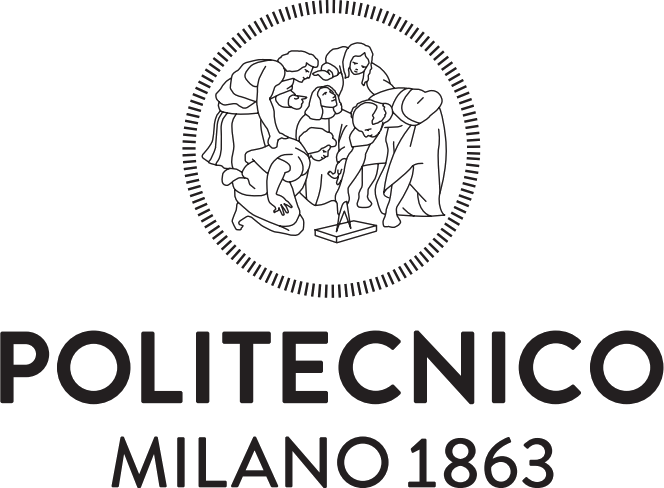

# Network Measurements and Data Analysis Lab

**Professor Alessandro Enrico Cesare Redondi**

**Moein Taherinezhad - 240265**

**Home Work No.2**




The goal of this homework is to implement and test a website fingerprinting approach able to classify what website is visited by a user observing only encrypted HTTPS traffic. Our approach will involve the following steps:


We will proceed by implementing the subsequent steps:

1. Traffic capture
2. Extraction of features
3. Dataset construction
4. Partitioning into train and test sets
5. Application of KNN classification
6. KNN classification using an alternate test set
7. Compilation of cumulative traces



A bash script was employed to capture the requested traffic generated by sending 10 requests to each website, with simultaneous filtering during capture **on March 27th**. Subsequently, statistical features for both flows and reverse flows were extracted, resulting in the creation of a dataset formatted as a DataFrame. Following this, the dataset was partitioned into a train set **70%** and a test set **30%**, and the classification process was conducted utilizing the KNN algorithm. Accuracy served as the evaluation metric. As a final step, a new test set was generated in a similar manner, albeit by capturing traffic generated through sending 3 requests to each website on March **28th**. KNN classification was executed using the same training set as previously employed.

The observed decline in performance is attributed to the daily fluctuations in the statistical characteristics of the traffic, stemming from the routine updates of news website homepages.









**1. Traffic Capture**


Within the Bash script that I used on my Linux system in VM, I implemented the capability to capture network traffic for **10** websites selected from the designated list for Homework No.2. Utilizing TShark, I applied a filter to exclude traffic beyond TCP connections or those exchanged solely between servers within the same data centers, representing internal traffic within the VM. To stimulate network traffic towards the designated websites, the Curl command was employed to dispatch **10** and subsequently **3** as New Dataset consecutive requests to each website on **March 27th** and then again on March **28th**. Finally, the captured traffic was stored in both pcap and csv formats within their respective directories.

In [2]:
#Please do not run this cell
!unzip '/content/Data.zip'
!unzip '/content/Data_Test.zip'

Archive:  /content/Data.zip
   creating: Data/
  inflating: Data/www.abc.net.au.csv  
  inflating: Data/www.bbc.co.uk.csv  
  inflating: Data/www.cnbc.com.csv   
  inflating: Data/www.express.co.uk.csv  
  inflating: Data/www.ndtv.com.csv   
  inflating: Data/www.news18.com.csv  
  inflating: Data/www.nypost.com.csv  
  inflating: Data/www.rt.com.csv     
  inflating: Data/www.timesofindia.com.csv  
  inflating: Data/www.washingtonpost.com.csv  
Archive:  /content/Data_Test.zip
   creating: Data_Test/
  inflating: Data_Test/www.abc.net.au.csv  
  inflating: Data_Test/www.bbc.co.uk.csv  
  inflating: Data_Test/www.cnbc.com.csv  
  inflating: Data_Test/www.express.co.uk.csv  
  inflating: Data_Test/www.ndtv.com.csv  
  inflating: Data_Test/www.news18.com.csv  
  inflating: Data_Test/www.nypost.com.csv  
  inflating: Data_Test/www.rt.com.csv  
  inflating: Data_Test/www.timesofindia.com.csv  
  inflating: Data_Test/www.washingtonpost.com.csv  


In [3]:
!apt-get install tshark

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8 libsbc1 libsmi2ldbl
  libspandsp2 libspeexdsp1 libwireshark-data libwireshark15 libwiretap12 libwsutil13
  wireshark-common
Suggested packages:
  mmdb-bin snmp-mibs-downloader geoipupdate geoip-database geoip-database-extra libjs-leaflet
  libjs-leaflet.markercluster wireshark-doc
The following NEW packages will be installed:
  libbcg729-0 libc-ares2 liblua5.2-0 libmaxminddb0 libnl-genl-3-200 libpcap0.8 libsbc1 libsmi2ldbl
  libspandsp2 libspeexdsp1 libwireshark-data libwireshark15 libwiretap12 libwsutil13 tshark
  wireshark-common
0 upgraded, 16 newly installed, 0 to remove and 39 not upgraded.
Need to get 23.0 MB of archives.
After this operation, 120 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmaxmindd

In [21]:
import ipaddress
import socket

from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [22]:
hostname = socket.gethostname()
global my_private_ip
my_private_ip = socket.gethostbyname(hostname)
my_private_ip


'172.28.0.12'

**Please do not run the following cell on google colab**

In [ ]:
%%shell


WEBSITES=" https://www.ndtv.com https://www.timesofindia.com https://www.express.co.uk https://www.washingtonpost.com https://www.rt.com https://www.news18.com https://www.cnbc.com https://www.abc.net.au https://www.bbc.co.uk https://www.nypost.com"

#Apply the BPF filter to ignore traffic between servers within the same data center and exclude non-TCP traffic.
FILTER="not (src net 172.16.0.0/12 && dst net 172.16.0.0/12) && tcp"

mkdir -p ./Data


#Initiate Tshark capture in the background for each website in the list, execute 10 Curl requests, and terminate Tshark afterward.
#To capture an alternate dataset, execute this cell 1 day later, generating 3 Curl requests.

for i in $WEBSITES
do
  echo $i
  tshark -i eth0 -T fields -E header=y -E separator=, -E occurrence=f -e frame.number \
  -e frame.time -e ip.len -e ip.proto -e ip.src -e ip.dst -e tcp.srcport -e tcp.dstport \
  -e tcp.len -f "${FILTER}" -w './Data/'${i:8}.pcap > ./Data/${i:8}.csv &


  #Waiting for Tshark to initialize
  sleep 1
  RUNNING_PID=$!
  for j in {1..10}
  do
    echo -e "\t Req #$j"
    curl -s $i > /dev/null

    #Pause for 5 seconds between consecutive captures.
    sleep 5
  done

  #Wait until the final HTTP request is completed before terminating the Tshark capture.
  sleep 1
  kill ${RUNNING_PID}
done
exit

**2. Extracting of Features**

To enhance precision in statistical analysis, distinct statistical features are computed for both flows and reverse flows. Initially, the function discerns the flow direction ("up" or "down") based on source and destination IP addresses, subsequently recording the corresponding source and destination TCP ports. Statistical features for flows are then calculated and stored within a dictionary.

In cases where a reverse flow exists, denoted by packets flowing in the opposite direction, the function iterates through identical steps to compute statistical features for the reverse flow. These features are stored in the flow_features dictionary with a reversed direction indicator.

Ultimately, the function yields the flow_features dictionary as its output

In [31]:
def up_or_down(src_ip):
  if (ipaddress.ip_address(src_ip).is_private and src_ip != my_private_ip):
    return 'up'
  else:
    return 'down'


In [33]:
def extract_features(flow,df_flow, reverse_flow, df_reverse_flow):
  flow_features = {}

  # Store the TCP ports based on the flow direction.
  direction = up_or_down(flow[0])
  if direction == 'up':
    flow_features['dport'] = flow[3]
    flow_features['sport'] = flow[2]
  else:
    flow_features['dport'] = flow[2]
    flow_features['sport'] = flow[3]

  # Calculating statistical features for input flows.
  pkt_sizes = df_flow['ip.len'].astype(float)
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
  flow_features['num_packets '+direction] = len(df_flow)
  flow_features['total_bytes '+direction] = pkt_sizes.sum()
  flow_features['min_pkt_size '+direction] = pkt_sizes.min()
  flow_features['max_pkt_size '+direction] = pkt_sizes.max()
  flow_features['mean_pkt_size '+direction] = pkt_sizes.mean()
  flow_features['std_pkt_size '+direction] = pkt_sizes.std()
  flow_features['min_iat '+direction] = iat.min()
  flow_features['max_iat '+direction] = iat.max()
  flow_features['mean_iat '+direction] = iat.mean()
  flow_features['std_iat '+direction] = iat.std()
  if not df_reverse_flow.empty:
    # Statistical feature computation for reverse input flows.
    if direction == 'up':
      reverse_direction='down'
    else:
      reverse_direction='up'

    flow_features['num_packets '+reverse_direction] = len(df_reverse_flow)
    pkt_sizes = df_reverse_flow['ip.len'].astype(float)
    flow_features['total_bytes '+reverse_direction] = pkt_sizes.sum()
    flow_features['min_pkt_size '+reverse_direction] = pkt_sizes.min()
    flow_features['max_pkt_size '+reverse_direction] = pkt_sizes.max()
    flow_features['mean_pkt_size '+reverse_direction] = pkt_sizes.mean()
    flow_features['std_pkt_size '+reverse_direction] = pkt_sizes.std()
    iat = pd.to_datetime(df_reverse_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
    flow_features['min_iat '+reverse_direction] = iat.min()
    flow_features['max_iat '+reverse_direction] = iat.max()
    flow_features['mean_iat '+reverse_direction] = iat.mean()
    flow_features['std_iat '+reverse_direction] = iat.std()

  return flow_features

**3.Dataset construction**

Data is grouped by source and destination IP addresses, as well as TCP source and destination ports, within a Pandas DataFrame generated from a CSV file. The function extract_features is invoked, receiving flow data and its associated reverse flow data, if available, resulting in the generation of a feature dictionary.

It's noteworthy that previously analyzed reverse flows are monitored in the to_ignore_flows list to prevent redundant processing. Upon encountering a reverse flow during processing, its tuple counterpart is appended to the to_ignore_flows list. This tracking mechanism ensures each flow, along with its corresponding reverse flow, undergoes processing only once.

In [34]:
path = '/content/Data'
files = [f for f in listdir(path) if isfile(join(path, f))]

biflow_features = pd.DataFrame()
for f in files:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df_tcp = pd.read_csv(join(path,f))
    df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows = []
    for flow,df_flow in df_flows_tcp:
      if flow not in to_ignore_flows:

        reverse_flow = (flow[1], flow[0], flow[3], flow[2])

        if reverse_flow in df_flows_tcp.groups:
          df_reverse_flow = df_flows_tcp.get_group(reverse_flow)
          to_ignore_flows.append(reverse_flow)
        else:
          df_reverse_flow = pd.DataFrame()

        flow_features = extract_features(flow, df_flow, reverse_flow, df_reverse_flow)
        flow_features['website'] = f[4:len(f)-4]
        biflow_features = biflow_features.append(flow_features,ignore_index=True)

Processing file   www.bbc.co.uk.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

Processing file   www.abc.net.au.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

Processing file   www.cnbc.com.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

Processing file   www.timesofindia.com.csv
Processing file   www.ndtv.com.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

Processing file   www.washingtonpost.com.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

Processing file   www.news18.com.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

Processing file   www.rt.com.csv
Processing file   www.express.co.uk.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

Processing file   www.nypost.com.csv


<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2c987be5447>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features = biflow_features.append(flow_features,ignore_index=True)
<ipython-input-34-a2

**4.Partitioning into train and test sets**

In [35]:
X = biflow_features.drop(['sport','dport'],axis=1).dropna();
Y = X['website']
X = X.drop(['website'],axis=1)

# Normalization
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


seed =42
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.3, shuffle=True, random_state = seed)

To ensure consistent outcomes upon algorithm execution, I pseudo-randomly set the random state for the train-test split. However, for further analysis, accuracy assessment can be conducted by iterating through different seeds to identify the seed yielding the highest accuracy.


**5.Application of KNN classification**

In [37]:
ACCURACY = []
for k in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn.fit(X_train, Y_train)
  knn_predict = knn.predict(X_test)
  accuracy = accuracy_score(Y_test, knn_predict)
  ACCURACY.append(accuracy)
  print('K =',k,'->',accuracy)

K = 1 -> 1.0
K = 2 -> 1.0
K = 3 -> 0.9666666666666667
K = 4 -> 0.9666666666666667
K = 5 -> 0.9666666666666667
K = 6 -> 0.9666666666666667
K = 7 -> 0.9666666666666667
K = 8 -> 0.9666666666666667
K = 9 -> 0.9666666666666667
K = 10 -> 0.9666666666666667


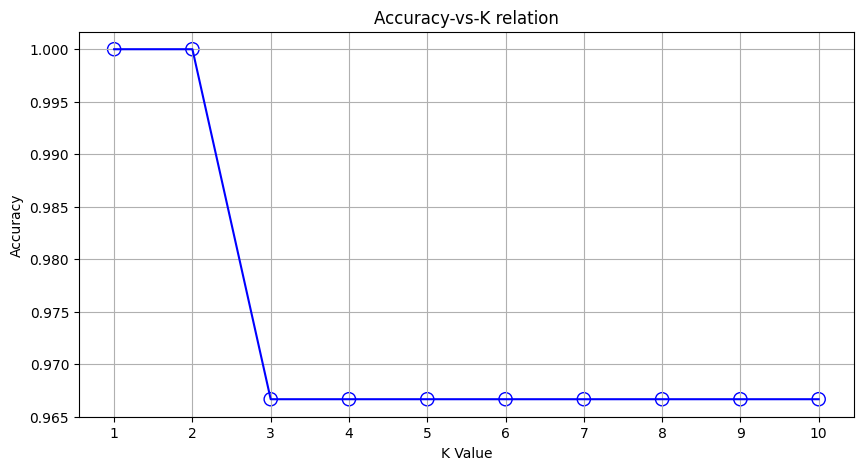

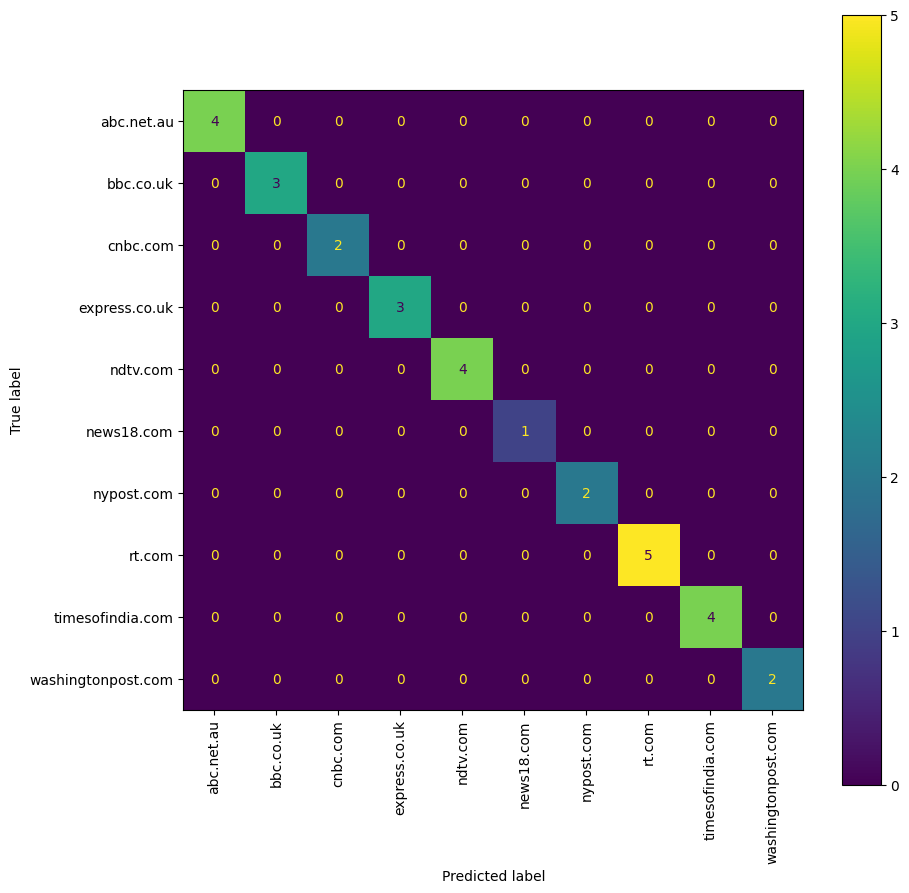

In [38]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.grid(True)
ax.set_title("Accuracy-vs-K relation")
ax.set_xlabel("K Value")
ax.set_ylabel("Accuracy")
ax.set_xticks(range(1,11))
_ = ax.plot(range(1,11), ACCURACY, 'b')
_ = ax.scatter(range(1,11), ACCURACY, s=90, facecolors='none', edgecolors='b')


k = ACCURACY.index(max(ACCURACY))+1
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn.fit(X_train, Y_train)
knn_predict = knn.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 10));
cm_display = ConfusionMatrixDisplay.from_predictions(knn_predict, Y_test, ax=ax);
cm_display.ax_.set_xticklabels(cm_display.ax_.get_xticklabels(), rotation=90)
plt.show()

**6.KNN classification using an alternate test set**

In [39]:
path = '/content/Data_Test'
files = [f for f in listdir(path) if isfile(join(path, f))]

biflow_features_new = pd.DataFrame()
for f in files:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df_tcp_new = pd.read_csv(join(path,f))
    df_flows_tcp_new = df_tcp_new.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows_new = []
    for flow_new,df_flow_new in df_flows_tcp_new: #flow is a tuple representing the flow, df_flow is the dataframe with all packets of the flow
      if flow_new not in to_ignore_flows_new: # ignore the already analyzed reverse flows
        # if exists the reverse flow get its dataframe, otherwise set df_reverse_flow as empty dataframe
        reverse_flow_new = (flow_new[1], flow_new[0], flow_new[3], flow_new[2])

        if reverse_flow_new in df_flows_tcp_new.groups:
          df_reverse_flow_new = df_flows_tcp_new.get_group(reverse_flow_new)
          to_ignore_flows_new.append(reverse_flow_new)
        else:
          df_reverse_flow_new = pd.DataFrame()

        flow_features_new = extract_features(flow_new, df_flow_new, reverse_flow_new, df_reverse_flow_new)
        flow_features_new['website'] = f[4:len(f)-4]
        biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)

Processing file   www.bbc.co.uk.csv
Processing file   www.abc.net.au.csv


<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.cnbc.com.csv
Processing file   www.timesofindia.com.csv


<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.ndtv.com.csv
Processing file   www.washingtonpost.com.csv


<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.news18.com.csv


<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

Processing file   www.rt.com.csv
Processing file   www.express.co.uk.csv
Processing file   www.nypost.com.csv


<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_features_new,ignore_index=True)
<ipython-input-39-ca8b753076ff>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  biflow_features_new = biflow_features_new.append(flow_feat

In [40]:
X_new = biflow_features_new.drop(['sport','dport'],axis=1).dropna();
Y_test_new = X_new['website']
X_new = X_new.drop(['website'],axis=1)

# Normalization
X_norm_new = scaler.fit_transform(X_new)
X_test_new = X_norm_new

In [42]:
ACCURACY_new = []
for k in range(1,11):
  knn_new = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn_new.fit(X_train, Y_train)
  knn_new_predict = knn_new.predict(X_test_new)
  accuracy_new = accuracy_score(Y_test_new, knn_new_predict)
  ACCURACY_new.append(accuracy_new)
  print('K =',k,'->',accuracy_new)

K = 1 -> 0.6
K = 2 -> 0.6
K = 3 -> 0.6
K = 4 -> 0.6
K = 5 -> 0.6
K = 6 -> 0.6
K = 7 -> 0.6
K = 8 -> 0.6
K = 9 -> 0.6
K = 10 -> 0.6


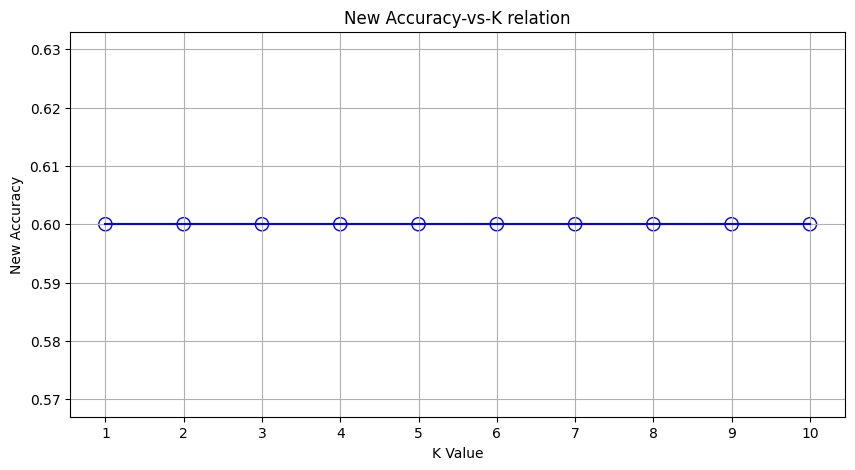

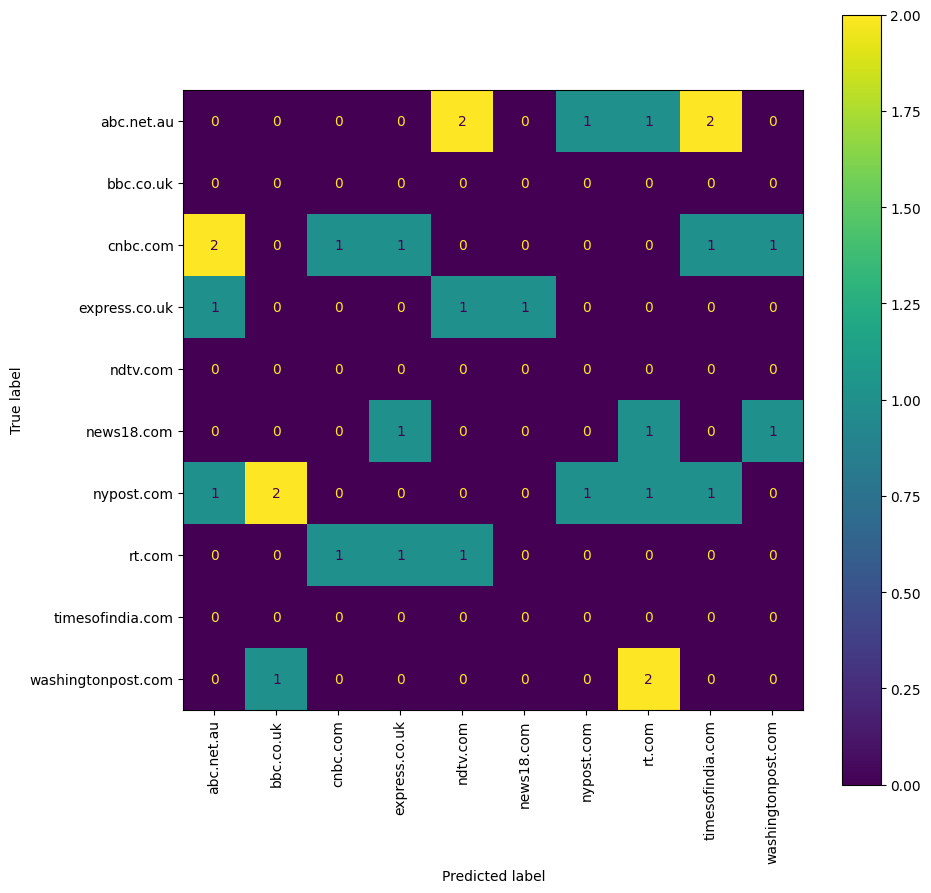

In [43]:
# Plot accuracy_new over K
fig, ax = plt.subplots(figsize=(10, 5));
ax.grid(True)
ax.set_title("New Accuracy-vs-K relation")
ax.set_xlabel("K Value")
ax.set_ylabel("New Accuracy")
ax.set_xticks(range(1,11))
_ = ax.plot(range(1,11), ACCURACY_new, 'b')
_ = ax.scatter(range(1,11), ACCURACY_new, s=90, facecolors='none', edgecolors='b')

fig, ax = plt.subplots(figsize=(10, 10));


k = ACCURACY_new.index(max(ACCURACY_new))+1
knn_new = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_new.fit(X_train, Y_train)
knn_new_predict = knn_new.predict(X_test_new)
cm_display_new = ConfusionMatrixDisplay.from_predictions(knn_new_predict, Y_test, ax=ax);
cm_display_new.ax_.set_xticklabels(cm_display_new.ax_.get_xticklabels(), rotation=90)
plt.show()

# **The observed decline in performance is noteworthy, indicating a significant reduction. This decline appears to be attributed to the dynamic nature of news websites, which frequently update their homepages in response to emerging news. Consequently, such alterations impact the generated traffic, thereby challenging the generalizability of KNN classification. Specifically, the feasibility of utilizing features from one day to classify traffic on another day is compromised.**

# **7. Compilation of cumulative traces**

The function computes the cumulative function of data packets within a network flow. It begins by adding a new field, "downlink," to each packet in the data frames based on the direction parameter. Packets in the df_flow dataFrame are labeled as False if the direction is "up," and True if the direction is "down," with labels reversed for packets in the df_reverse_flow dataFrame.

Next, packets with non-zero values for the "tcp.len" and "ip.len" fields are selected, and the two dataFrames are merged into a single dataFrame (df_join). TCP ACK packets are then filtered out.

Finally, utilizing the 'ip.len' field of the df_join data frame, the cumulative function is computed using Numpy's cumsum() and where() methods. The value of the packet's "ip.len" field is either added to or subtracted from the cumulative total based on whether it travels uplink or downlink. The resulting cumulative sum is stored in the c_func variable.

The cumulative function starts with a zero inserted at the beginning of the c_func array, and the resulting array is returned as the function's output

In [44]:
def get_cumulative_func(direction, df_flow, df_reverse_flow):
    # add the field 'downlink' to all packets to store its direction
    if direction == 'up':
        df_flow['downlink'] = False
        df_reverse_flow['downlink'] = True
    else:
        df_flow['downlink'] = True
        df_reverse_flow['downlink'] = False

    # combine the flow dataframes and filter out non-data TCP ACK packets
    df_join = pd.concat([df_flow, df_reverse_flow])
    df_join = df_join[(df_join['tcp.len'] > 0) & (df_join['ip.len'] > 0)]

    # compute the cumulative function using numpy cumsum and where functions
    c_func = np.cumsum(np.where(df_join['downlink'], df_join['ip.len'], -df_join['ip.len']))

    # prepend a zero to the cumulative function to represent the start
    c_func = np.insert(c_func, 0, 0)

    return c_func

In [46]:
pd.options.mode.chained_assignment = None  # default='warn'
path = '/content/Data'
tsharkfiles = [f for f in listdir(path) if isfile(join(path, f))]

flow_cum_traces = pd.DataFrame(columns=['c_func', 'website'])

for f in tsharkfiles:
  if (f.startswith('www') and f.endswith('.csv')):
    print('Processing file  ', f)
    df = pd.read_csv(join(path,f))
    df_tcp = df[df["ip.proto"] == 6]
    df_flows_tcp = df_tcp.groupby(["ip.src","ip.dst","tcp.srcport","tcp.dstport"])
    to_ignore_flows = []
    for flow,df_flow in df_flows_tcp:
      if flow not in to_ignore_flows:
        reverse_flow = (flow[1], flow[0], flow[3], flow[2])
        if reverse_flow in df_flows_tcp.groups:
          df_reverse_flow = df_flows_tcp.get_group(reverse_flow)
          to_ignore_flows.append(reverse_flow)
        else:
          df_reverse_flow = pd.DataFrame()

        c_func = get_cumulative_func(up_or_down(flow[0]), df_flow, df_reverse_flow)
        flow_cum_traces.loc[len(flow_cum_traces.index)] = [c_func, f[4:len(f)-4]]

flow_cum_traces

Processing file   www.bbc.co.uk.csv
Processing file   www.abc.net.au.csv
Processing file   www.cnbc.com.csv
Processing file   www.timesofindia.com.csv
Processing file   www.ndtv.com.csv
Processing file   www.washingtonpost.com.csv
Processing file   www.news18.com.csv
Processing file   www.rt.com.csv
Processing file   www.express.co.uk.csv
Processing file   www.nypost.com.csv


,c_func,website
0,"[0, 4384, 4821, 4923, 5006, 9390, 13774, 18158...",bbc.co.uk
1,"[0, 2940, 4821, 4923, 5006, 7946, 10886, 12382...",bbc.co.uk
2,"[0, 4384, 4821, 4932, 9316, 13700, 18084, 2069...",bbc.co.uk
3,"[0, 4384, 4821, 4932, 9316, 13700, 18084, 2070...",bbc.co.uk
4,"[0, 4384, 4821, 4932, 9316, 13700, 18084, 2069...",bbc.co.uk
...,...,...
95,"[0, 557, 677, 763, 852, 927, 1029, 1100, 1164,...",nypost.com
96,"[0, 557, 677, 763, 852, 927, 1029, 1100, 1164,...",nypost.com
97,"[0, 557, 677, 763, 852, 927, 1029, 1100, 1164,...",nypost.com
98,"[0, 557, 677, 763, 852, 927, 1029, 1100, 1164,...",nypost.com


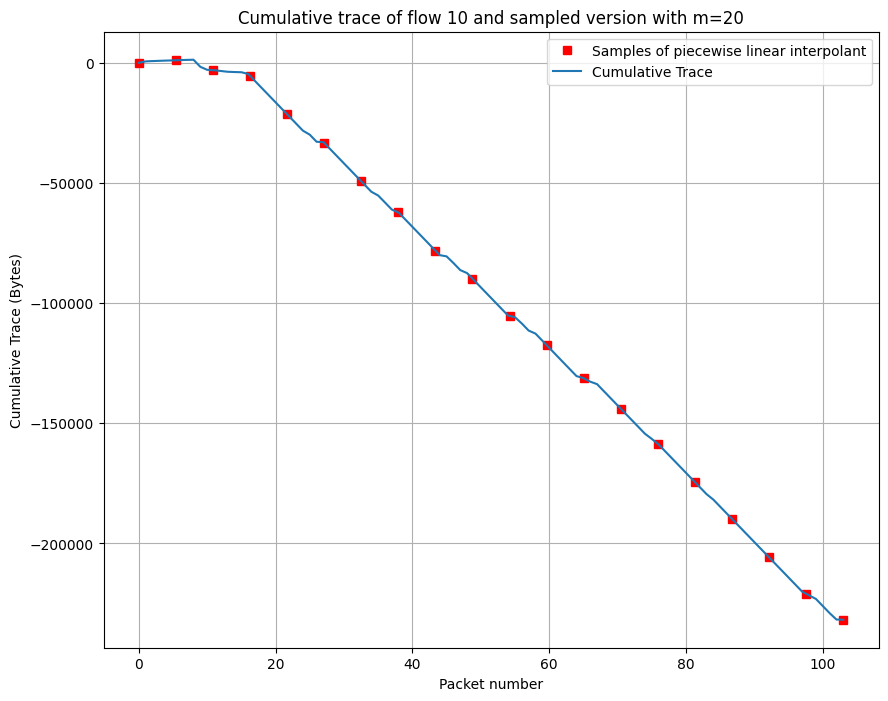

In [51]:
#visualizing the first row of the cumulative trace dataFrame

m = 20 # Number of samples of piecewise linear interpolant of the cumulative function
num_flow = 10 # flow number+
flow_prints = flow_cum_traces.loc[num_flow].c_func
end_packet = len(flow_prints)

x_vals = range(0, end_packet)
x_interp = np.linspace(0, end_packet-1, num=m)
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_interp, np.interp(x_interp, x_vals, flow_prints), 'rs', label='Samples of piecewise linear interpolant')
ax.plot(x_vals, flow_prints, label='Cumulative Trace')
ax.legend()
ax.set_title('Cumulative trace of flow '+str(num_flow)+' and sampled version with m='+str(m))
ax.set_xlabel('Packet number')
ax.set_ylabel('Cumulative Trace (Bytes)')
ax.grid()

In [52]:
# Creating X_trace and Y_trace
cols = []
for i in range(0,m):
  cols.append("Sample #"+str(i))
X_trace = pd.DataFrame(columns=cols)

for idx, flow in flow_cum_traces.iterrows():
  fp = flow_cum_traces.loc[idx].c_func
  xp = range(0, len(fp))
  x = np.linspace(0, len(fp)-1, num=m)
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)

Y_trace = flow_cum_traces['website']

# Normalization
scaler = StandardScaler()
X_trace_norm = scaler.fit_transform(X_trace)

#train-test split (reminder: Here, I also fixed the random state with the same seed)
X_trace_train, X_trace_test, Y_trace_train, Y_trace_test = train_test_split(X_trace_norm, Y_trace, test_size=0.3, shuffle=True, random_state=seed)

<ipython-input-52-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)
<ipython-input-52-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)
<ipython-input-52-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace = X_trace.append(dict(zip(X_trace.columns, np.interp(x, xp, fp).tolist())), ignore_index=True)
<ipython-input-52-fd99f8f1ab2a>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_trace

In [53]:
ACCURACY_TRACE = []

for k in range(1,11):
  knn_trace = KNeighborsClassifier(n_neighbors=k, weights='distance')
  knn_trace.fit(X_trace_train, Y_trace_train)
  knn_predict_trace = knn_trace.predict(X_trace_test)
  accuracy_trace = accuracy_score(Y_trace_test, knn_predict_trace)
  ACCURACY_TRACE.append(accuracy_trace)
  print('K =',k,'->',accuracy_trace)

K = 1 -> 0.9333333333333333
K = 2 -> 0.9333333333333333
K = 3 -> 0.9333333333333333
K = 4 -> 0.9333333333333333
K = 5 -> 0.9666666666666667
K = 6 -> 0.9333333333333333
K = 7 -> 0.9666666666666667
K = 8 -> 0.9666666666666667
K = 9 -> 0.9666666666666667
K = 10 -> 0.9666666666666667


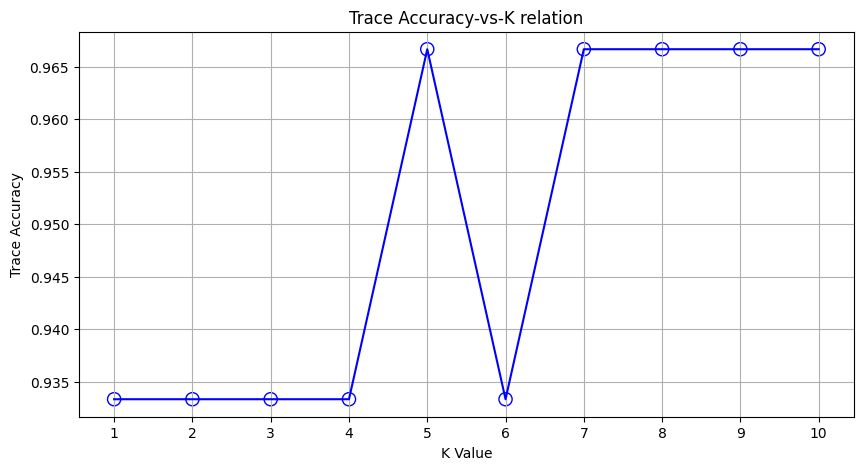

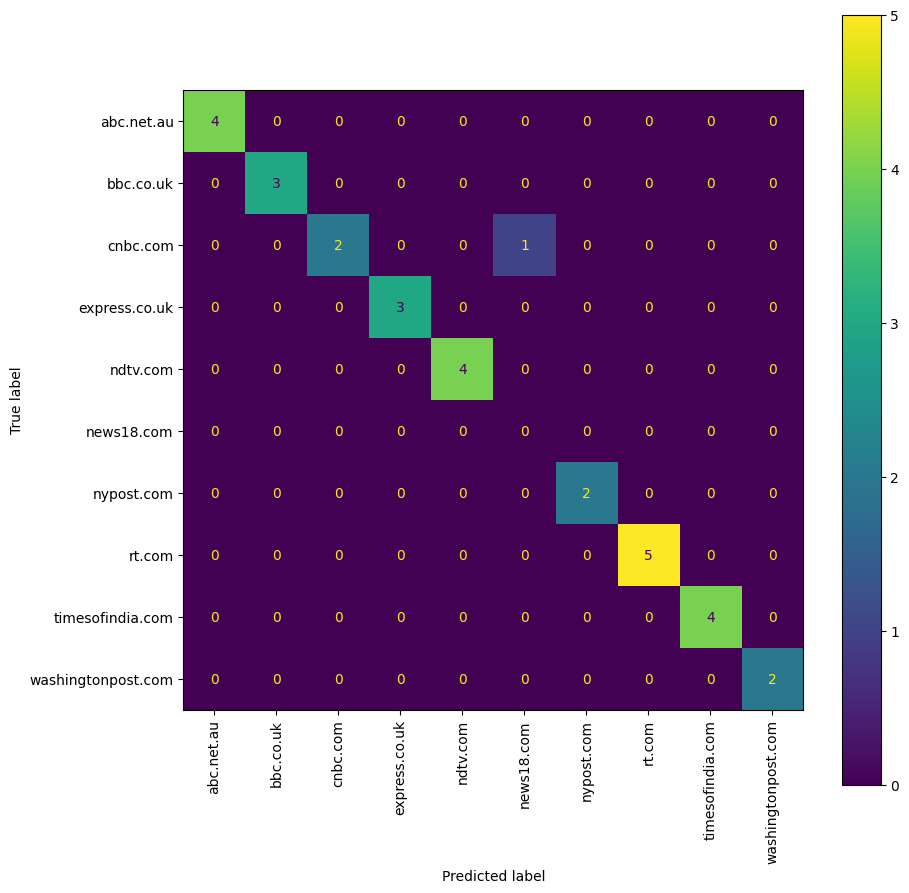

In [54]:
# Plot accuracy_new over K
fig, ax = plt.subplots(figsize=(10, 5));
ax.grid(True)
ax.set_title("Trace Accuracy-vs-K relation")
ax.set_xlabel("K Value")
ax.set_ylabel("Trace Accuracy")
ax.set_xticks(range(1,11))
_ = ax.plot(range(1,11), ACCURACY_TRACE, 'b')
_ = ax.scatter(range(1,11), ACCURACY_TRACE, s=90, facecolors='none', edgecolors='b')

fig, ax = plt.subplots(figsize=(10, 10));

#confusion matrix for best k
k = ACCURACY_TRACE.index(max(ACCURACY_TRACE))+1
knn_trace = KNeighborsClassifier(n_neighbors=k, weights='distance')
knn_trace.fit(X_trace_train, Y_trace_train)
knn_predict_trace = knn_trace.predict(X_trace_test)
cm_display_trace = ConfusionMatrixDisplay.from_predictions(knn_predict_trace, Y_trace_test, ax=ax);
cm_display_trace.ax_.set_xticklabels(cm_display_trace.ax_.get_xticklabels(), rotation=90)
plt.show()

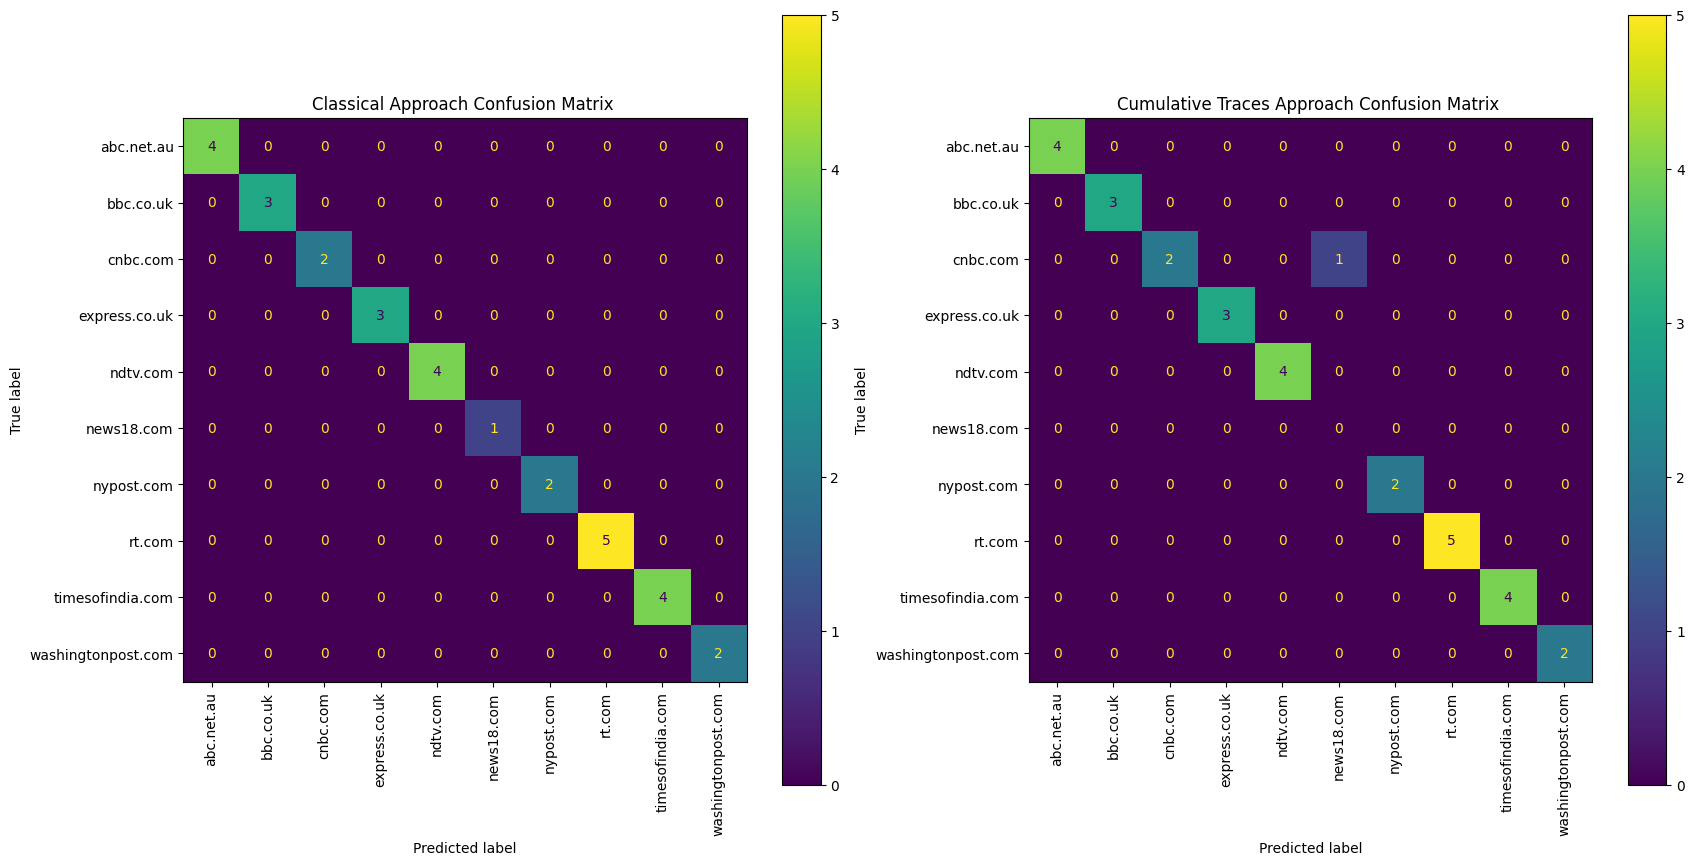

In [55]:
#Plotting Confusion matrices sid-by-side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first confusion matrix on the first subplot
cm_display = ConfusionMatrixDisplay.from_predictions(knn_predict, Y_test, ax=ax[0])
cm_display.ax_.set_xticklabels(cm_display.ax_.get_xticklabels(), rotation=90)
ax[0].set_title('Classical Approach Confusion Matrix ')

# Plot the second confusion matrix on the second subplot
cm_display_trace = ConfusionMatrixDisplay.from_predictions(knn_predict_trace, Y_trace_test, ax=ax[1])
cm_display_trace.ax_.set_xticklabels(cm_display_trace.ax_.get_xticklabels(), rotation=90)
ax[1].set_title('Cumulative Traces Approach Confusion Matrix ')

# Display the plots
plt.show()


# As evident from the analysis, the performance outcomes of both approaches exhibit a similarity.